In [ ]:
!pip install datasets transformers
!pip install -q "fsspec==2023.9.2"
!pip install -q --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.4/173.4 kB 4.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2023.9.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-runtime-cu12==12.4.127; platform_system == "Linux" a

In [ ]:
import re
import string
import ast
import nltk
import pandas as pd

nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

df = pd.read_csv("all-udemy-courses.csv")

def light_clean(text):
    text = str(text).lower().strip()
    return re.sub(r'\s+', ' ', text)


def join_objectives(obj_str):
    try:
        obj_list = ast.literal_eval(obj_str)
        if isinstance(obj_list, list):
            return ' '.join(obj_list)
    except:
        return ''
    return ''

df["objectives_clean"] = df["objectives"].astype(str).apply(join_objectives)
df["input"] = df["title"].fillna('') + " " + df["objectives_clean"].fillna('')
df["input"] = df["input"].astype(str).apply(light_clean)

df["output"] = df["headline"].astype(str).str.strip()
df = df[(df["input"].str.strip() != '') & (df["output"].str.strip() != '')]
df = df.dropna(subset=["input", "output"])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(df[["input", "output"]].head(3))

                                               input  \
0  unreal engine 5 - 3d game art fantasy swords -...   
1  javascript best practices - a hands-on profess...   
2  urban planning tools: introduction to nyc zoni...   

                                              output  
0  Create multiple game ready sword props and int...  
1  Write cleaner, faster, more secure and perform...  
2                              Bronx Building Design  


In [ ]:
def prepare_input(row):
    objectives = "\n".join(eval(row["objectives"])) if isinstance(row["objectives"], str) else ""
    return f"Course Title: {row['title']}\nObjectives:\n{objectives}"


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token
model.resize_token_embeddings(len(tokenizer))
model.config.pad_token_id = tokenizer.pad_token_id

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

from datasets import Dataset
train_data = Dataset.from_pandas(df_train)
test_data = Dataset.from_pandas(df_test)

In [ ]:
print(df.columns)

Index(['id', 'title', 'url', 'headline', 'rating', 'num_reviews',
       'num_subscribers', 'instructor', 'is_paid', 'price', 'content_length',
       'instructional_level', 'last_update_date', 'language', 'is_bestseller',
       'objectives', 'category', 'objectives_clean', 'input', 'output'],
      dtype='object')


Token indices sequence length is longer than the specified maximum sequence length for this model (1163 > 1024). Running this sequence through the model will result in indexing errors


Min: 4
Max: 1163
Mean: 50.47815144766147
95th percentile: 94.0


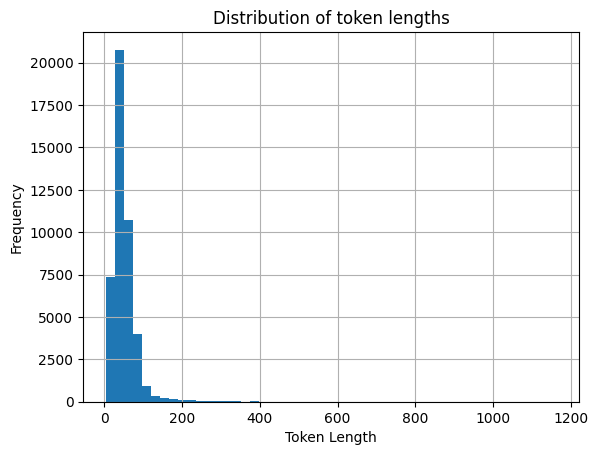

In [ ]:
import matplotlib.pyplot as plt
token_lengths = df["input"].apply(lambda x: len(tokenizer.tokenize(x)))

print("Min:", token_lengths.min())
print("Max:", token_lengths.max())
print("Mean:", token_lengths.mean())
print("95th percentile:", token_lengths.quantile(0.95))

plt.hist(token_lengths, bins=50)
plt.title("Distribution of token lengths")
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
def tokenize_function(examples):
    full_input = [inp + tokenizer.eos_token + out for inp, out in zip(examples["input"], examples["output"])]
    model_inputs = tokenizer(
        full_input,
        max_length=256,
        truncation=True,
        padding="max_length",
    )
    model_inputs["labels"] = model_inputs["input_ids"].copy()
    return model_inputs


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./chatbot_model",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="epoch",
    learning_rate=3e-5,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    report_to="none"
)

In [ ]:
tokenized_train = train_data.map(tokenize_function, batched=True)
tokenized_test = test_data.map(tokenize_function, batched=True)


Map:   0%|          | 0/35920 [00:00<?, ? examples/s]

Map:   0%|          | 0/8980 [00:00<?, ? examples/s]

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
)

trainer.train()


/tmp/ipython-input-17-1628357638.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.932700,0.900368
2,0.883800,0.882157


TrainOutput(global_step=8980, training_loss=0.934765139029658, metrics={'train_runtime': 5544.8725, 'train_samples_per_second': 12.956, 'train_steps_per_second': 1.62, 'total_flos': 9385609789440000.0, 'train_loss': 0.934765139029658, 'epoch': 2.0})

In [ ]:
#!pip install nltk sentence-transformers scikit-learn

In [ ]:
import torch
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

smoothie = SmoothingFunction().method4
sbert = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
model.eval()

generated_outputs = []
true_outputs = test_data["output"]
inputs = test_data["input"]

# توليد إجابات من الموديل
for question in tqdm(inputs):
    input_ids = tokenizer(question, return_tensors="pt", padding=True, truncation=True, max_length=128).input_ids.to(model.device)

    with torch.no_grad():
        generated_ids = model.generate(
        input_ids=input_ids,
        attention_mask=(input_ids != tokenizer.pad_token_id),
        max_new_tokens=64,
        num_beams=5,
        early_stopping=True,
        pad_token_id=tokenizer.eos_token_id
        )

        output = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

    generated_outputs.append(output)

# حساب BLEU و Cosine
bleu_scores = []
cosine_scores = []

for ref, gen in zip(true_outputs, generated_outputs):
    bleu = sentence_bleu([ref.split()], gen.split(), smoothing_function=smoothie)
    bleu_scores.append(bleu)

    embeddings = sbert.encode([ref, gen])
    cosine_sim = cosine_similarity([embeddings[0]], [embeddings[1]])[0][0]
    cosine_scores.append(cosine_sim)

# الطباعة النهائية
print("\n التقييم النهائي:")
print(f"Average BLEU Score: {sum(bleu_scores)/len(bleu_scores):.4f}")
print(f"Average Cosine Similarity: {sum(cosine_scores)/len(cosine_scores):.4f}")


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

100%|██████████| 8980/8980 [23:37<00:00,  6.34it/s]



 التقييم النهائي:
Average BLEU Score: 0.0154
Average Cosine Similarity: 0.6315


In [ ]:
# حفظ النموذج بعد التدريب
save_path = "./my_finetuned_gpt2"
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)
print(f"✅ Fine-tuned model saved to: {save_path}")


✅ Fine-tuned model saved to: ./my_finetuned_gpt2


In [ ]:
def generate_headline(input_text, max_new_tokens=64):
    model.eval()
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding="max_length"
    ).to(model.device)

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=5,
            early_stopping=True,
            no_repeat_ngram_size=2
        )

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text


In [ ]:
test_input = "Course Description: Learn Python programming from scratch. Understand variables, loops, functions, and build real-world projects.\nCourse Headline:"
print(generate_headline(test_input))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Course Description: Learn Python programming from scratch. Understand variables, loops, functions, and build real-world projects.
Course Headline:Learn Python Programming from Scratch.


In [ ]:
test_input = "Course Description: machine learning from scratch \nCourse Headline:"
print(generate_headline(test_input))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Course Description: machine learning from scratch 
Course Headline:Learn Machine Learning from Scratch with hands-on labs.
